In [1]:
# Importing an ipynb file from another ipynb file
!pip install ipynb

# Importing functions from another jupyter notebook
!pip install nbimporter

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm

class SpambaseDatasetLoader():
    
    def __init__(self):
        print('init Loader notebook')
    
    def load_dataset(self, url='https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data'):
        print('Loading dataset.')
        
        columns = [
            'word_freq_make',
            'word_freq_address',
            'word_freq_all',
            'word_freq_3d',
            'word_freq_our',
            'word_freq_over',
            'word_freq_remove',
            'word_freq_internet',
            'word_freq_order',
            'word_freq_mail',
            'word_freq_receive',
            'word_freq_will',
            'word_freq_people',
            'word_freq_report',
            'word_freq_addresses',
            'word_freq_free',
            'word_freq_business',
            'word_freq_email',
            'word_freq_you',
            'word_freq_credit',
            'word_freq_your',
            'word_freq_font',
            'word_freq_000',
            'word_freq_money',
            'word_freq_hp',
            'word_freq_hpl',
            'word_freq_george',
            'word_freq_650',
            'word_freq_lab',
            'word_freq_labs',
            'word_freq_telnet',
            'word_freq_857',
            'word_freq_data',
            'word_freq_415',
            'word_freq_85',
            'word_freq_technology',
            'word_freq_1999',
            'word_freq_parts',
            'word_freq_pm',
            'word_freq_direct',
            'word_freq_cs',
            'word_freq_meeting',
            'word_freq_original',
            'word_freq_project',
            'word_freq_re',
            'word_freq_edu',
            'word_freq_table',
            'word_freq_conference',
            'char_freq_;',
            'char_freq_(',
            'char_freq_[',
            'char_freq_!',
            'char_freq_$',
            'char_freq_#',
            'capital_run_length_average',
            'capital_run_length_longest',
            'capital_run_length_total',
            'spam_nonspam']
        
        # retrieve the spam data from icu.
        spam_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data', header=None, names=columns, index_col=False)

        # make the label the first feature.
        spam_data.insert(0, 'target_spam_nonspam', spam_data['spam_nonspam'])
        spam_data = spam_data.drop('spam_nonspam', axis = 1)

        # save the data to new csv.
        spam_data.to_csv('./datasets/spambase_all.csv', index = False)
        print('Loading spambase_all.csv completed.')
            
        spam = spam_data[spam_data['target_spam_nonspam']==1]
        non_spam = spam_data[spam_data['target_spam_nonspam']==0]
        non_spam = non_spam.sample(n=len(spam), random_state=101)
        spam_data_balance = pd.concat([spam,non_spam],axis=0)            
        print('Loading spambase_balance.csv completed.')
    
    def get_full_dataset(self):
        print('get_balance_all')
        return pd.read_csv('./datasets/spambase_all.csv')        
    
    def get_balance_dataset(self): 
        print('get_balance_data')
        return pd.read_csv('./datasets/spambase_balance.csv')

    def backward_elimitation(self, x, Y, sl, columns):
        numVars = len(x[0])
        for i in range(0, numVars):
            regressor_OLS = sm.OLS(Y, x).fit()
            maxVar = max(regressor_OLS.pvalues).astype(float)
            if maxVar > sl:
                for j in range(0, numVars - i):
                    if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                        x = np.delete(x, j, 1)
                        columns = np.delete(columns, j)
        regressor_OLS.summary()
        return x, columns    
    
    
    def perform_feature_selection(self, data, SL=0.05):        
        print('The shape before feature selection: {}'.format(data.shape))
        selected_columns = data.columns
        selected_columns = selected_columns[1:].values
        
        data_modeled, selected_columns = self.backwardElimination(data.iloc[:,1:].values, data.iloc[:,0].values, SL, selected_columns)
        
        result = pd.DataFrame()
        result['target_spam_nonspam'] = data.iloc[:,0]
        
        new_data = pd.DataFrame(data = data_modeled, columns = selected_columns)
        print('The shape after feature selection: {}'.format(new_data.shape))
        return new_data        

In [3]:
import nbimporter
import spambase_dataset_loader_nb

loader = spambase_dataset_loader_nb.SpambaseDatasetLoader()

init Loader notebook


In [4]:
loader.load_dataset()

Loading dataset.
Loading spambase_all.csv completed.
Loading spambase_balance.csv completed.


get_balance_all


<AxesSubplot:xlabel='target_spam_nonspam', ylabel='count'>

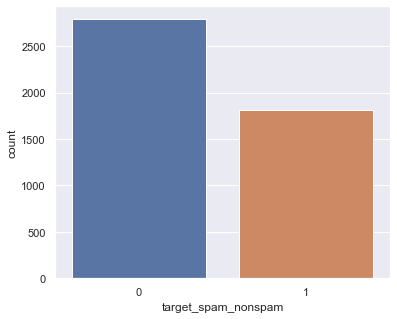

In [5]:
import seaborn as sns
sns.set(rc={"figure.figsize":(6, 5)})

full_dataset = loader.get_full_dataset()  
sns.countplot(x='target_spam_nonspam', data=full_dataset) 

get_balance_data


<AxesSubplot:xlabel='target_spam_nonspam', ylabel='count'>

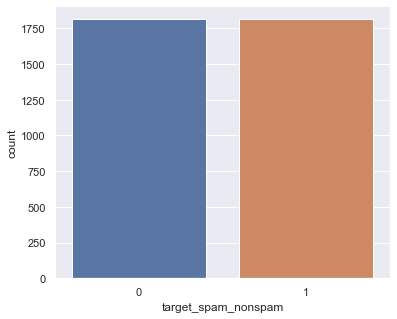

In [6]:
balance_dataset = loader.get_balance_dataset()
sns.countplot(x='target_spam_nonspam', data=balance_dataset) 

In [7]:
new_balance_dataset = loader.perform_feature_selection(balance_dataset)

The shape before feature selection: (3626, 58)


AttributeError: 'SpambaseDatasetLoader' object has no attribute 'backwardElimination'